In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run ../global_variables.py ./
%run ../global_functions.py ./

In [3]:
%matplotlib notebook

basins=load_basins_data(approximate=True)

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

In [5]:
Nbasins=basins.shape[0]
Ndatasets=1694
data_TWS='GRACE_JPL_mascons'
min_year=2003
max_year=2014

NSEc_tab=pd.read_csv("../results/water_budget/NSE_cyclic_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])
NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])
perc_months_tab=pd.read_csv("../results/water_budget/GRACE_uncertainty_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])

basins_gamma=pd.read_csv('../results/basins_gamma.csv',index_col=[0])

Maximum over all combinations of the different parameters (not necessarily achieved for the same combination)

In [6]:
best_perf=pd.Series(np.max(NSEc_tab,axis=1),index=NSEc_tab.index,name='max NSEc').to_frame()
best_perf['max NSE']=np.max(NSE_tab,axis=1)
best_perf['area']=basins['geometry'].to_crs('epsg:6933').area/1e6
best_perf['nb positive NSEc']=np.sum(NSEc_tab>=0,axis=1)
best_perf['max perc months']=np.max(perc_months_tab,axis=1)
best_perf.sort_values(by='max NSEc',ascending=False)

,max NSEc,max NSE,area,nb positive NSEc,max perc months
PARANA,0.709236,0.909193,2.639954e+06,455,99.290780
BRAZOS,0.657111,0.797857,1.185678e+05,592,95.744681
JAGUARIBE,0.650368,0.807736,7.317369e+04,768,77.304965
DANUBE,0.628426,0.903778,7.973351e+05,513,92.907801
SAO FRANCISCO,0.627346,0.862709,6.348415e+05,839,88.652482
...,...,...,...,...,...
LAKE GAIRDNER,-1.137183,-0.649241,1.129553e+05,0,97.872340
HAYES,-1.204932,-0.199026,1.080354e+05,0,100.000000
RHARSA,-1.223324,-0.801116,1.143265e+05,0,95.035461
AMAZON,-1.282651,0.915111,5.941000e+06,0,81.560284


Adds the 10th best NSE to highlight basins with very specific conditions to close the water budget.

In [7]:
for basin_name in NSE_tab.index:
    best_perf.loc[basin_name,'10th NSE']=NSE_tab.loc[basin_name].sort_values(ascending=False).iloc[10]
    best_perf.loc[basin_name,'10th NSEc']=NSEc_tab.loc[basin_name].sort_values(ascending=False).iloc[10]
best_perf

,max NSEc,max NSE,area,nb positive NSEc,max perc months,10th NSE,10th NSEc
WINISK,-0.040765,0.603721,6.591133e+04,0,87.943262,0.534045,-0.223758
COPPER,0.223633,0.916692,6.609492e+04,27,39.716312,0.908215,0.144632
NOTTAWAY,-0.212348,0.689401,6.626976e+04,0,70.921986,0.513411,-0.899282
TALAS,0.139281,0.823368,6.630754e+04,9,78.014184,0.787535,-0.035329
MARONI,0.428930,0.875050,6.611601e+04,78,63.829787,0.844854,0.290926
...,...,...,...,...,...,...,...
Tibetan plateau,-0.598178,0.605817,5.905340e+05,0,96.453901,0.558567,-0.789750
Western Plateau,0.561589,0.753869,1.993775e+06,359,96.453901,0.689387,0.446734
Puna de Atacama plateau,-0.671468,0.233532,1.016363e+05,0,100.000000,0.136998,-0.881985
Salinas Grandes,0.080348,0.234398,1.549168e+05,3,100.000000,0.108671,-0.070679


# 1. Explore GRACE uncertainty

Correlation between error (NSE or cyclic NSE) and GRACE uncertainty (percentage of months where the budget reconstruction falls between GRACE uncertainty bounds).

<IPython.core.display.Javascript object>


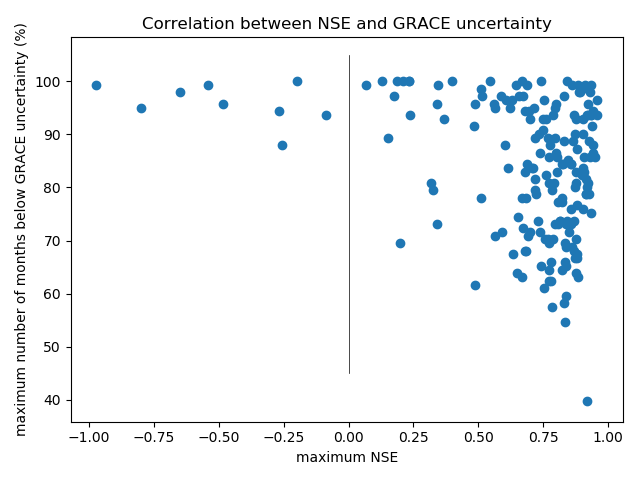

In [8]:
plt.figure()
plt.plot([0,0],[45,105],'k',linewidth=0.5)
plt.scatter(best_perf['max NSE'],best_perf['max perc months'])
#plt.legend(loc='lower right',fontsize='small')
#plt.xlim([-1.9,1])
#plt.ylim([50,102])
plt.xlabel('maximum NSE')
plt.ylabel('maximum number of months below GRACE uncertainty (%)')
plt.title('Correlation between NSE and GRACE uncertainty')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


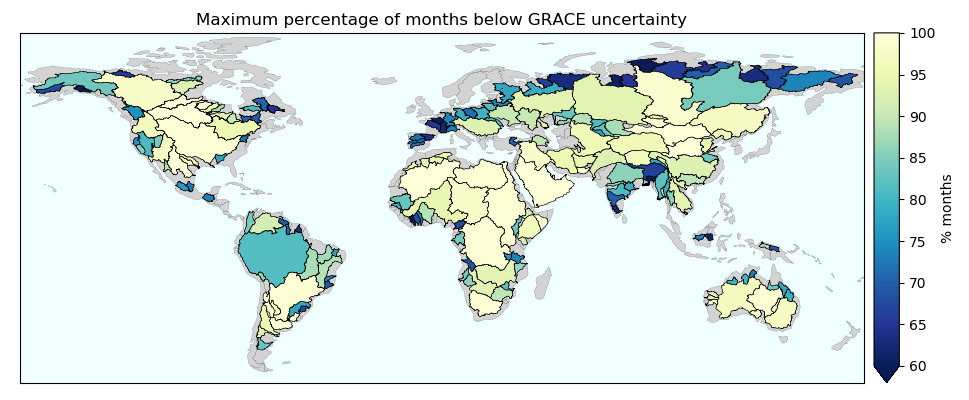

In [9]:
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

basins_plot=basins.copy()
basins_plot['max perc months']=best_perf['max perc months']

cmap = plt.get_cmap('YlGnBu_r')  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the .jet map
cmap = LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N) # create the new map
bounds = np.array([60,70,80,90,95,100]) # define the bins and normalize
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
basins_plot.plot(ax=ax,column='max perc months',edgecolor='black',linewidth=0.4,
                 cmap=cmap,#norm=norm,
                 vmin=60,vmax=100,
                 legend=True,cax=cax,
                legend_kwds={'label': "% months",
                              'extend':'min'
                          },)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('Maximum percentage of months below GRACE uncertainty')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


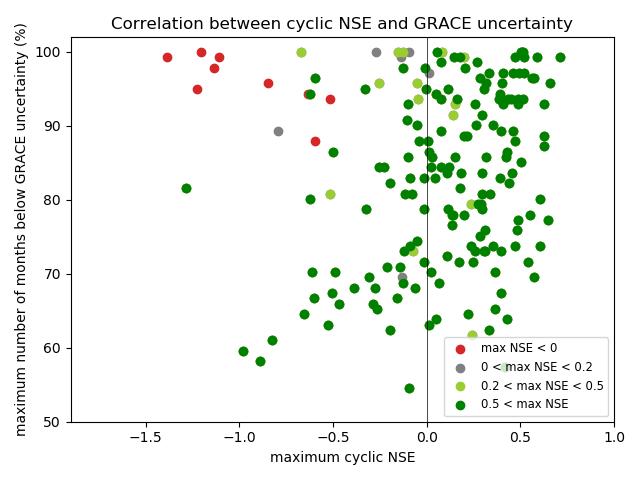

In [10]:
plt.figure()
plt.plot([0,0],[0,105],'k',linewidth=0.5)
plt.scatter(best_perf.loc[best_perf['max NSE']<0,'max NSEc'],
            best_perf.loc[best_perf['max NSE']<0,'max perc months'],label='max NSE < 0',color='tab:red')
plt.scatter(best_perf.loc[best_perf['max NSE']>0,'max NSEc'],
            best_perf.loc[best_perf['max NSE']>0,'max perc months'],label='0 < max NSE < 0.2',color='grey')
plt.scatter(best_perf.loc[best_perf['max NSE']>0.2,'max NSEc'],
            best_perf.loc[best_perf['max NSE']>0.2,'max perc months'],label='0.2 < max NSE < 0.5',color='yellowgreen')
plt.scatter(best_perf.loc[best_perf['max NSE']>0.5,'max NSEc'],
            best_perf.loc[best_perf['max NSE']>0.5,'max perc months'],label='0.5 < max NSE',color='green')
plt.legend(loc='lower right',fontsize='small')
plt.xlim([-1.9,1])
plt.ylim([50,102])
plt.xlabel('maximum cyclic NSE')
plt.ylabel('maximum number of months below GRACE uncertainty (%)')
plt.title('Correlation between cyclic NSE and GRACE uncertainty')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


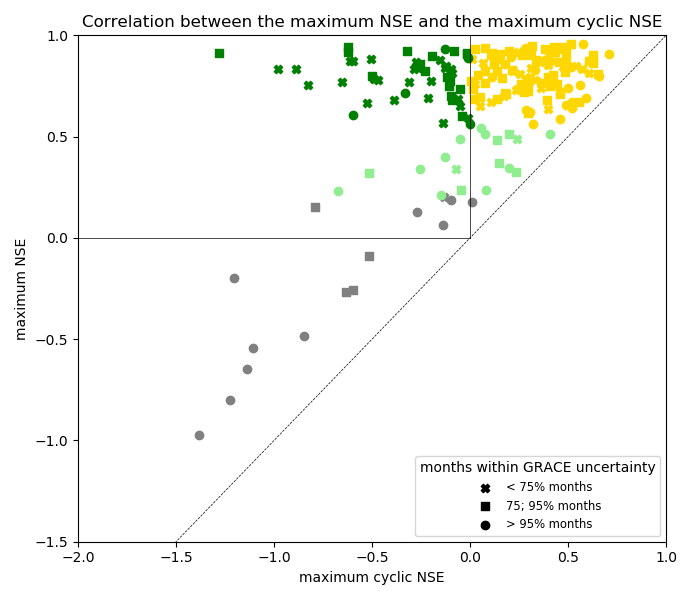

In [11]:
index_poor=best_perf.loc[best_perf['max NSE']<=0.2].index
index_lightgreen=best_perf.loc[(best_perf['max NSE']>0.2)&(best_perf['max NSE']<=0.55)].index
index_green=best_perf.loc[(best_perf['max NSE']>0.55)&(best_perf['max NSEc']<0)].index
index_gold=best_perf.loc[(best_perf['max NSE']>0.55)&(best_perf['max NSEc']>0)].index

plt.figure(figsize=(7,6))
plt.plot([0,0],[0,1.5],'k',linewidth=0.5)
plt.plot([-2,0],[0,0],'k',linewidth=0.5)
plt.plot([-2,1],[-2,1],'k--',linewidth=0.5)
plt.scatter(-10,-10,color='black',marker='X',label='< 75% months')
plt.scatter(-10,-10,color='black',marker='s',label='75; 95% months')
plt.scatter(-10,-10,color='black',marker='o',label='> 95% months')

list_perc_months=[0,75,95,100]
list_markers=['X','s','o']
for i in range(len(list_perc_months)-1):
    m1=list_perc_months[i]
    m2=list_perc_months[i+1]
    
    plt.scatter(best_perf.loc[index_poor].loc[(best_perf['max perc months']<=m2)&(best_perf['max perc months']>m1),
                                              'max NSEc'],
                best_perf.loc[index_poor].loc[(best_perf['max perc months']<=m2)&(best_perf['max perc months']>m1),
                                              'max NSE'],
                color='grey',marker=list_markers[i])

    plt.scatter(best_perf.loc[index_lightgreen].loc[(best_perf['max perc months']<=m2)&(best_perf['max perc months']>m1),
                                              'max NSEc'],
                best_perf.loc[index_lightgreen].loc[(best_perf['max perc months']<=m2)&(best_perf['max perc months']>m1),
                                              'max NSE'],
                color='lightgreen',marker=list_markers[i])
    
    plt.scatter(best_perf.loc[index_green].loc[(best_perf['max perc months']<=m2)&(best_perf['max perc months']>m1),
                                              'max NSEc'],
                best_perf.loc[index_green].loc[(best_perf['max perc months']<=m2)&(best_perf['max perc months']>m1),
                                              'max NSE'],
                color='green',marker=list_markers[i])
    
    plt.scatter(best_perf.loc[index_gold].loc[(best_perf['max perc months']<=m2)&(best_perf['max perc months']>m1),
                                              'max NSEc'],
                best_perf.loc[index_gold].loc[(best_perf['max perc months']<=m2)&(best_perf['max perc months']>m1),
                                              'max NSE'],
                color='gold',marker=list_markers[i])

plt.legend(loc='lower right',fontsize='small',title='months within GRACE uncertainty')
plt.xlabel('maximum cyclic NSE')
plt.ylabel('maximum NSE')
plt.title('Correlation between the maximum NSE and the maximum cyclic NSE')
plt.xlim([-2,1])
plt.ylim([-1.5,1])
plt.tight_layout()
plt.show()

# 1.2. Correlation between budget closure and various parameters

### Correlation with basin size

<IPython.core.display.Javascript object>


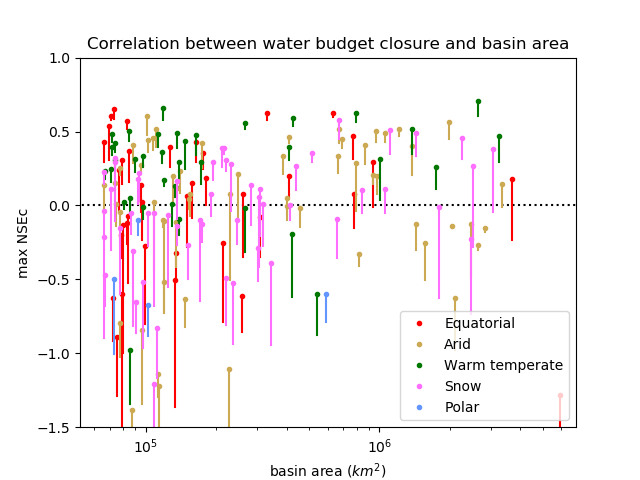

c:\users\fafal\miniconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


In [13]:
basins=load_basins_data()

variable='max NSEc' # 'max NSE' or 'max NSEc'

plt.figure()
plt.plot([best_perf['area'].min()-1e5,best_perf['area'].max()+1e6],[0,0],'k:')
for clim in np.unique(basins['MAIN_CLIMATE']):
    plt.semilogx(best_perf.loc[basins['MAIN_CLIMATE']==clim,'area'],
                 best_perf.loc[basins['MAIN_CLIMATE']==clim,variable],'.',
                 color=climate_color_dict[clim],
                 label=climate_name_dict[clim])
    plt.semilogx(np.array([best_perf.loc[basins['MAIN_CLIMATE']==clim,'area'],
                           best_perf.loc[basins['MAIN_CLIMATE']==clim,'area']]),
                 [best_perf.loc[basins['MAIN_CLIMATE']==clim,'10th {}'.format(variable[4:])],
                  best_perf.loc[basins['MAIN_CLIMATE']==clim,variable]],
                 color=climate_color_dict[clim])
plt.xlim([best_perf['area'].min()-1e5,best_perf['area'].max()+1e6])
plt.ylim([-1.5,1])
plt.xlabel('basin area ($km^2$)')
plt.ylabel(variable)
plt.title('Correlation between water budget closure and basin area')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='lower right')
plt.show()

In [14]:
(r,p)=pearsonr(best_perf['area'].values,best_perf['max NSEc'].values)
#(r,p)=pearsonr(best_perf.loc[basins['CLIMATE']==clim,'area'].values,best_perf.loc[basins['CLIMATE']==clim,'max NSE'].values)
if p>0.05:
    print('The correlation r={:.2f} is not statistically significant (p={:.2f})'.format(r,p))
else:
    print('The correlation r={:.2f} is statistically significant (p={:.2f})'.format(r,p))

The correlation r=0.01 is not statistically significant (p=0.90)


### Correlation with gamma parameter (how close from the mean monthly cycle)

The correlation with gamma, r=-0.26 is statistically significant (p=0.000)


<IPython.core.display.Javascript object>


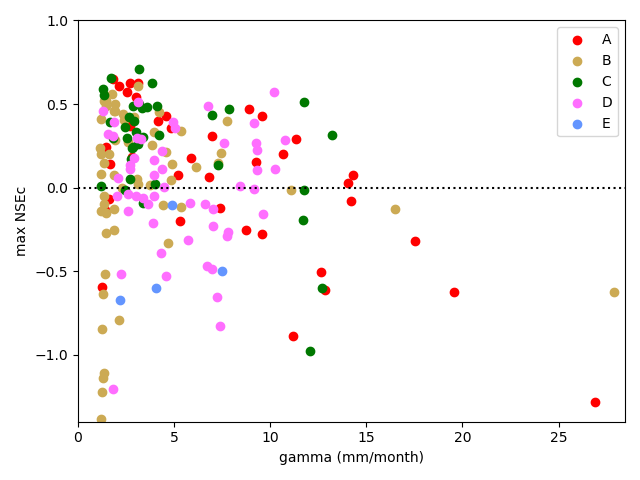

In [16]:
basins_gamma=pd.read_csv('../results/basins_gamma.csv',index_col=[0])
basins_gamma['err cycle norm']=basins_gamma['err cycle']/basins_gamma['amplitude']

variable_x='gamma' # magnitude or gamma 
variable_y='max NSEc' # max NSE or max NSEc
(r,p)=pearsonr(best_perf.join(basins_gamma)[variable_x].values,best_perf[variable_y].values)
if p>0.05:
    print('The correlation with {}, r={:.2f} is not statistically significant (p={:.2f})'.format(variable_x,r,p))
else:
    print('The correlation with {}, r={:.2f} is statistically significant (p={:.3f})'.format(variable_x,r,p))
    
plt.figure()
plt.plot([0,1.02*basins_gamma[variable_x].max()],[0,0],'k:')
for clim in ['A','B','C','D','E']:
    plt.scatter(best_perf.join(basins_gamma).loc[basins['MAIN_CLIMATE']==clim,variable_x],
                best_perf.loc[basins['MAIN_CLIMATE']==clim,variable_y],
                color=climate_color_dict[clim],
                label=clim)
plt.legend()
plt.xlim([0,1.02*basins_gamma[variable_x].max()])
plt.ylim([-1.4,1])
plt.xlabel(variable_x
           +' (mm/month)'
          )
plt.ylabel(variable_y)
plt.tight_layout()
plt.show()

### Correlation with the annual components

In [17]:
annual_P=pd.read_csv('../results/annual_comp/P.csv',index_col=[0])
annual_ET=pd.read_csv('../results/annual_comp/ET.csv',index_col=[0])
annual_R=pd.read_csv('../results/annual_comp/R.csv',index_col=[0])

P_mean=np.mean(annual_P,axis=1)
ET_mean=np.mean(annual_ET,axis=1)
R_mean=np.mean(annual_R,axis=1)

The correlation r=0.34 is statistically significant (p=0.00)


<IPython.core.display.Javascript object>


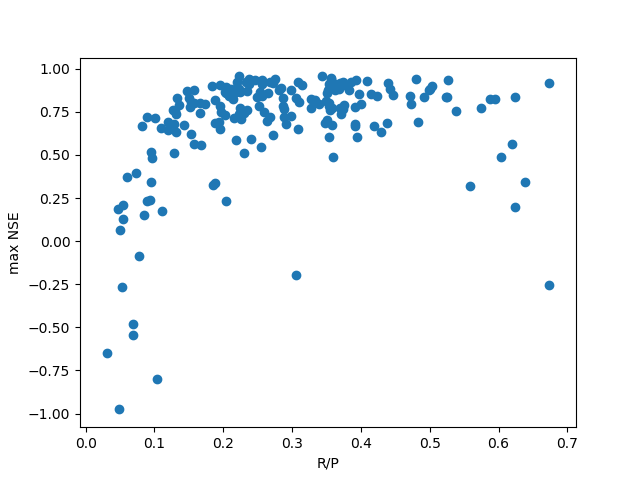

In [18]:
X=(R_mean/P_mean).loc[best_perf.index]
variable_Y='max NSE'
(r,p)=pearsonr(X.values,best_perf[variable_Y].values)
#(r,p)=pearsonr(best_perf.loc[basins['CLIMATE']==clim,'area'].values,best_perf.loc[basins['CLIMATE']==clim,'max NSE'].values)
if p>0.05:
    print('The correlation r={:.2f} is not statistically significant (p={:.2f})'.format(r,p))
else:
    print('The correlation r={:.2f} is statistically significant (p={:.2f})'.format(r,p))
    
plt.figure()
plt.scatter(X,best_perf[variable_Y])
plt.xlabel('R/P')
plt.ylabel(variable_Y)
plt.show()

# Maximum NSE depending on climate zone

In [19]:
basins=load_basins_data(approximate=False)

<IPython.core.display.Javascript object>


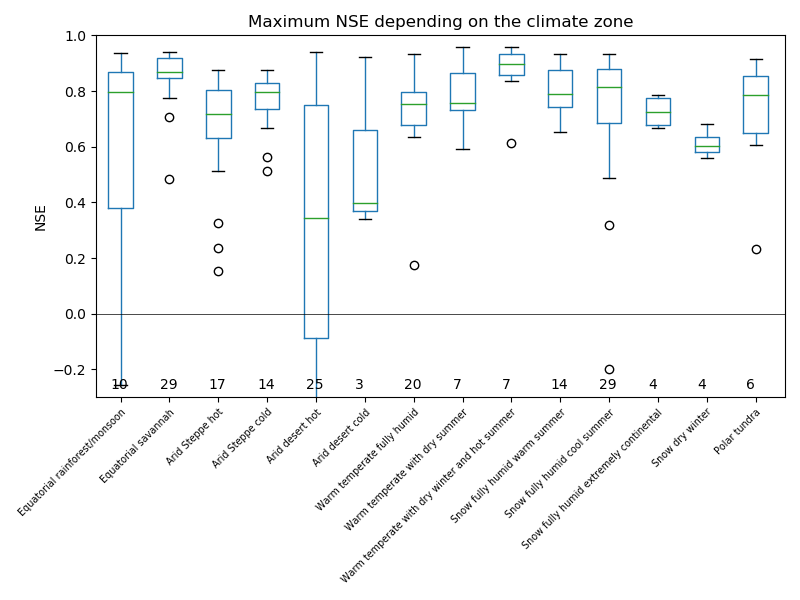

In [20]:
variable='max NSE'
df=basins['MAIN_CLIMATE'].to_frame().join(best_perf[variable])

df.boxplot(column=[variable],by='MAIN_CLIMATE',figsize=(8,6),grid=False)
i=0.8
list_climate_name=[]
for index,row in df.groupby('MAIN_CLIMATE').count().iterrows():
    if variable=='max NSE':
        plt.text(i,-0.27,str(row[0]))
    elif variable=='max NSEc':
        plt.text(i,-0.95,str(row[0]))
    list_climate_name.append(climate_name_dict[index])
    i+=1
plt.plot([0,i],[0,0],'k',linewidth=0.5)
plt.xticks(np.arange(1,i),list_climate_name,rotation=45, ha="right", rotation_mode="anchor",fontsize='x-small')
plt.xlim([0.5,i-0.2])
plt.xlabel('')
plt.ylabel(variable[4:])
if variable=='max NSE':
    plt.ylim([-0.3,1])
    plt.title('Maximum NSE depending on the climate zone')
elif variable=='max NSEc':
    plt.ylim([-1,1])
    plt.title('Maximum cyclostationary NSE depending on the climate zone')
plt.suptitle('')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


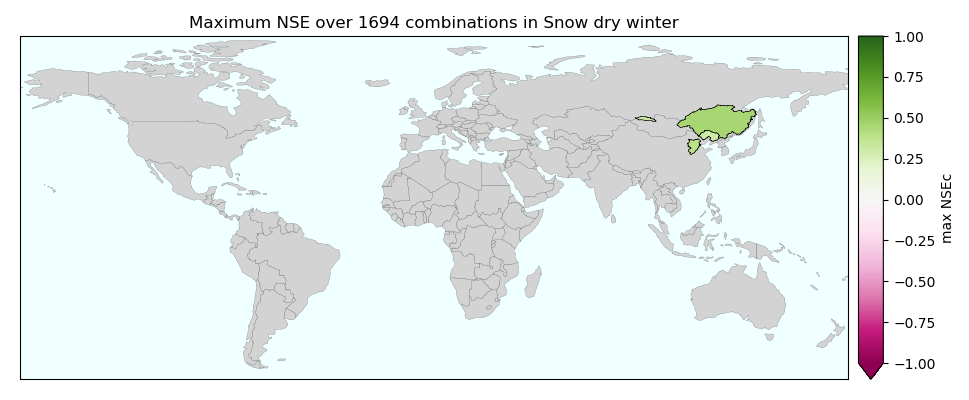

In [26]:
clim='Dw'
variable='max NSEc'

basins_plot=basins.copy()
if variable=='max NSE':
    basins_plot[variable]=np.nanmax(NSE_tab.loc[basins.index],axis=1)
    cmap=plt.cm.get_cmap('YlGn')
    vmin=0
else:
    basins_plot[variable]=np.nanmax(NSEc_tab.loc[basins.index],axis=1)
    cmap=plt.cm.get_cmap('PiYG')
    vmin=-1

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
#basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
basins_plot.loc[basins['MAIN_CLIMATE']==clim].plot(ax=ax,column=variable,edgecolor='black',linewidth=0.4,
                 cmap=cmap,
                 vmin=vmin,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': variable,
                              'extend':'min'
                          },)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('Maximum NSE over {} combinations in {}'.format(Ndatasets, climate_name_dict[clim]))
plt.tight_layout()
plt.show()

# 2. Understand water budget closure in different basins

## 2.1. Who are the basins with a poor NSE?

In [24]:
my_index=best_perf.loc[(best_perf['max NSE']<=0.2)].index
best_perf.loc[my_index].loc[:,['area','max NSE','max NSEc','max perc months']].sort_values(by='max NSEc').round({'area':0,
                                                    'max NSEc':2,'max NSE':2,'max perc months':1})

,area,max NSE,max NSEc,max perc months
MURCHISON,87419.0,-0.97,-1.38,99.3
RHARSA,114326.0,-0.80,-1.22,95.0
HAYES,108035.0,-0.20,-1.20,100.0
LAKE GAIRDNER,112955.0,-0.65,-1.14,97.9
Ogaden plateau,226784.0,-0.54,-1.11,99.3
DRAA,95772.0,-0.48,-0.85,95.7
YAQUI,77233.0,0.15,-0.79,89.4
MELRHIR,146309.0,-0.27,-0.63,94.3
MAMBERAMO,78667.0,-0.26,-0.60,87.9
GUIR,119939.0,-0.09,-0.52,93.6


<IPython.core.display.Javascript object>


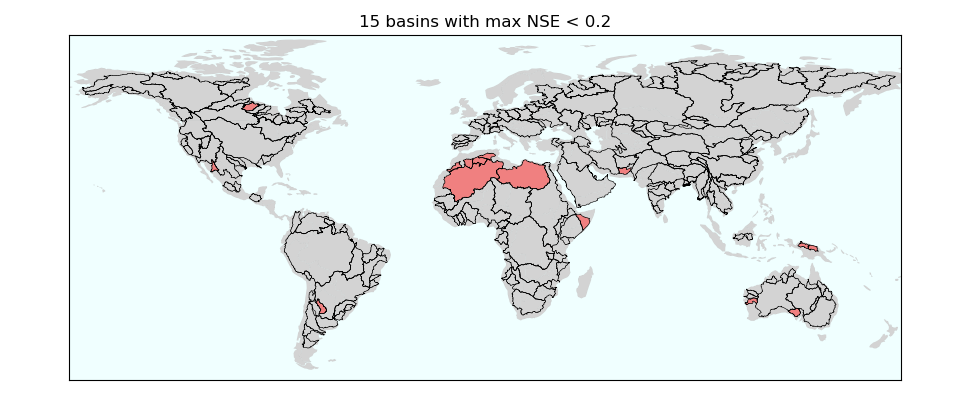

In [25]:
fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.01)
basins.boundary.plot(ax=ax,color='black',linewidth=0.4)
basins.loc[my_index].plot(ax=ax,color='lightcoral',linewidth=0.4)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('{} basins with max NSE < 0.2'.format(my_index.shape[0]))
plt.tight_layout()
plt.show()

## 1.2. Who are the basins with acceptable NSE?

In [26]:
my_index=best_perf.loc[(best_perf['max NSE']>=0.2)&(best_perf['max NSE']<=0.55)&(best_perf['max NSEc']<=0)].index
best_perf.loc[my_index].loc[:,['area','max NSE','max NSEc','max perc months']].sort_values(by='max NSEc').round({'area':0,
                                                    'max NSEc':2,'max NSE':2,'max perc months':1})

,area,max NSE,max NSEc,max perc months
Puna de Atacama plateau,101636.0,0.23,-0.67,100.0
LA GRANDE,96982.0,0.32,-0.52,80.9
TARIM HE,1564536.0,0.34,-0.25,95.7
Arabian Peninsula,2817408.0,0.21,-0.15,100.0
"Gobi desert, Junggar and Turpan depressions",1429096.0,0.40,-0.13,100.0
KAPUAS,83505.0,0.34,-0.07,73.0
SEVERN,101606.0,0.49,-0.05,95.7
ASHBURTON,77785.0,0.24,-0.05,93.6


<IPython.core.display.Javascript object>


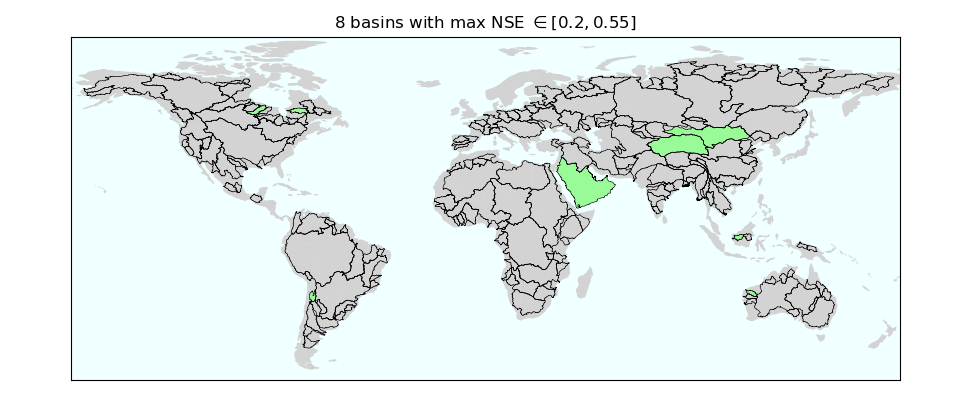

In [27]:
fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.01)
basins.boundary.plot(ax=ax,color='black',linewidth=0.4)
basins.loc[my_index].plot(ax=ax,color='palegreen',linewidth=0.4)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('{} basins with max NSE $\in [0.2, 0.55]$'.format(my_index.shape[0]))
plt.tight_layout()
plt.show()

## 1.3. Who are the basins with excellent NSE but poor cyclic NSE?

In [28]:
my_index=best_perf.loc[(best_perf['max NSEc']<=0)&(best_perf['max NSE']>=0.7)].index
best_perf.loc[my_index].loc[:,['area','max NSE','max NSEc','max perc months']].sort_values(by='max NSEc').round({'area':0,
                                                    'max NSEc':2,'max NSE':2,'max perc months':1})

,area,max NSE,max NSEc,max perc months
AMAZON,5941000.0,0.92,-1.28,81.6
MEGHNA,85391.0,0.84,-0.98,59.6
SASSANDRA,75013.0,0.83,-0.89,58.2
PUR,111981.0,0.75,-0.83,61.0
ANABAR,90493.0,0.77,-0.65,64.5
GAMBIA,72345.0,0.92,-0.62,80.1
NIGER,2115246.0,0.94,-0.62,94.3
KRISHNA,257907.0,0.87,-0.61,70.2
BRAHMAPUTRA,539989.0,0.87,-0.60,66.7
SANAGA,133047.0,0.88,-0.50,67.4


<IPython.core.display.Javascript object>


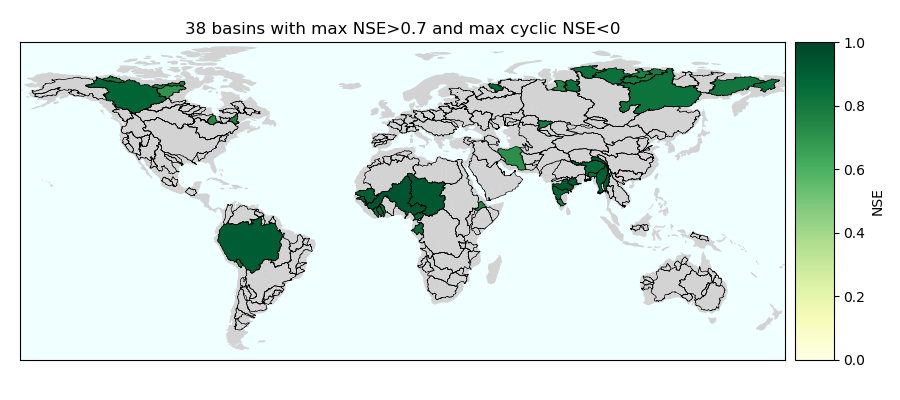

In [29]:
basins_plot=basins.loc[my_index.copy()]
basins_plot['max NSE']=best_perf.loc[my_index,'max NSE']

fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.01)
basins.boundary.plot(ax=ax,color='black',linewidth=0.4)
basins_plot.plot(ax=ax,column='max NSE',
                 cmap=plt.cm.get_cmap('YlGn'),
                 vmin=0,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "NSE",
                          },)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('{} basins with max NSE>0.7 and max cyclic NSE<0'.format(my_index.shape[0]))
plt.tight_layout()
plt.show()

## 1.4. Who are the basins with excellent cyclic NSE?

In [30]:
my_index=best_perf.loc[(best_perf['max NSEc']>0.1)].index
best_perf.loc[my_index].loc[:,['area','max NSE','max NSEc','max perc months']].sort_values(by='max NSEc').round({'area':0,
                                                    'max NSEc':2,'max NSE':2,'max perc months':1})

,area,max NSE,max NSEc,max perc months
YUKON,838177.0,0.90,0.11,83.7
SUSQUEHANNA,71076.0,0.67,0.11,72.3
SAINT LAWRENCE,1055756.0,0.80,0.11,95.0
SEVERNAYA DVINA,308661.0,0.91,0.11,78.7
GREAT SALT LAKE,136404.0,0.86,0.12,84.4
...,...,...,...,...
SAO FRANCISCO,634842.0,0.86,0.63,88.7
DANUBE,797335.0,0.90,0.63,92.9
JAGUARIBE,73174.0,0.81,0.65,77.3
BRAZOS,118568.0,0.80,0.66,95.7


<IPython.core.display.Javascript object>


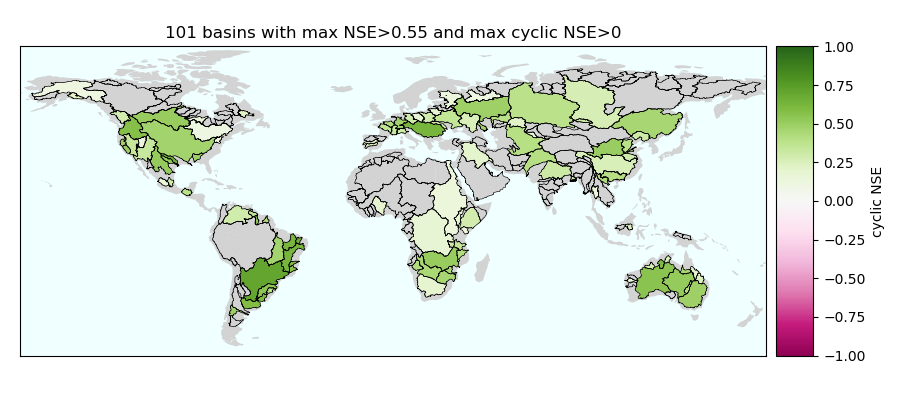

In [31]:
basins_plot=basins.loc[my_index.copy()]
basins_plot['max NSEc']=best_perf.loc[my_index,'max NSEc']

fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.01)
basins.boundary.plot(ax=ax,color='black',linewidth=0.4)
basins_plot.plot(ax=ax,column='max NSEc',
                 cmap=plt.cm.get_cmap('PiYG'),
                 vmin=-1,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "cyclic NSE",
                          },)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('{} basins with max NSE>0.55 and max cyclic NSE>0'.format(my_index.shape[0]))
plt.tight_layout()
plt.show()

# 3. Influence of NSE cost on other metrics

In [38]:
my_index=best_perf.loc[(best_perf['max NSEc']>0.1)].index
Sdiff=best_perf['max NSE'].values.reshape(basins.shape[0],1)-NSE_tab

# replace nans by 100, otherwise nans are summed as zeros
Sdiff=pd.DataFrame(np.where(np.isnan(Sdiff),100,Sdiff),Sdiff.index,Sdiff.columns)
Sdiff=Sdiff.loc[my_index]

max_cost=0.05

In [36]:
correlation_tab=pd.read_csv("../results/water_budget/correlation_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])
RMSE_tab=pd.read_csv("../results/water_budget/RMSE_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])

In [39]:
X=best_perf.loc[my_index]
X['max correlation']=np.nanmax(correlation_tab.loc[my_index],axis=1)
X['min RMSE']=np.nanmin(RMSE_tab.loc[my_index],axis=1)
X['min NSEc selection']=np.nanmin(pd.DataFrame(np.where(Sdiff<=max_cost,NSEc_tab.loc[my_index],np.nan),
                                                index=Sdiff.index,columns=Sdiff.columns),axis=1)
X['min correlation selection']=np.nanmin(pd.DataFrame(np.where(Sdiff<=max_cost,correlation_tab.loc[my_index],np.nan),
                                                index=Sdiff.index,columns=Sdiff.columns),axis=1)
X['max RMSE selection']=np.nanmax(pd.DataFrame(np.where(Sdiff<=max_cost,RMSE_tab.loc[my_index],np.nan),
                                                index=Sdiff.index,columns=Sdiff.columns),axis=1)
X

,max NSEc,max NSE,area,nb positive NSEc,max perc months,10th NSE,10th NSEc,max correlation,min RMSE,min NSEc selection,min correlation selection,max RMSE selection
COPPER,0.223633,0.916692,6.609492e+04,27,39.716312,0.908215,0.144632,0.964377,28.562051,-0.239051,0.941241,36.082815
TALAS,0.139281,0.823368,6.630754e+04,9,78.014184,0.787535,-0.035329,0.914248,8.981342,-0.102979,0.882067,10.167031
MARONI,0.428930,0.875050,6.611601e+04,78,63.829787,0.844854,0.290926,0.949184,26.289964,0.201610,0.913690,31.085154
GUADIANA,0.234628,0.729417,6.697940e+04,185,73.758865,0.708565,0.175645,0.867241,16.400407,0.093276,0.824303,17.850735
ESSEQUIBO,0.540419,0.847972,6.934148e+04,47,71.631206,0.771702,0.309857,0.923738,24.165936,0.428645,0.913789,26.944834
...,...,...,...,...,...,...,...,...,...,...,...,...
MISSISSIPPI,0.469833,0.932459,3.244506e+06,82,99.290780,0.910194,0.295063,0.971258,6.270253,0.078803,0.939936,8.265230
NILE,0.147321,0.882992,3.340877e+06,8,99.290780,0.861339,-0.010471,0.953150,6.392951,-0.208794,0.915162,7.611757
CONGO,0.178806,0.860302,3.689187e+06,4,99.290780,0.790052,-0.234147,0.940045,7.832134,-0.065795,0.908463,8.922655
Western Plateau,0.561589,0.753869,1.993775e+06,359,96.453901,0.689387,0.446734,0.870980,6.272187,0.474752,0.839985,6.865314


Selecting the NSE cost lower than 0.1 ensures a correlation not farther than 0.13 from the best correlation. Great!

In [40]:
(X['max correlation']-X['min correlation selection']).sort_values(ascending=False)

MAHAKAM           0.096200
BURDEKIN          0.069650
SAINT LAWRENCE    0.067046
TANA              0.061945
GASCOYNE          0.061804
                    ...   
THORGAY           0.018956
CUYUNI            0.016882
ESSEQUIBO         0.009949
UVS NUUR          0.008402
AMUR              0.001937
Length: 101, dtype: float64

Selecting the NSE cost lower than 0.1 ensures a RMSE smaller than 17mm/month. Great!

In [41]:
(X['max RMSE selection']-X['min RMSE']).sort_values(ascending=False)

TOCANTINS         7.710643
COPPER            7.520764
RUVUMA            6.702898
ORINOCO           6.511617
GANGES            6.253401
                    ...   
GASCOYNE          0.234107
UVS NUUR          0.207027
BANCANNIA LAKE    0.168188
AMUR              0.154982
ORANGE            0.104743
Length: 101, dtype: float64